## E-mail Automation With Exchangelib and Regex

This project shows us how we can automate e-mail responses with microsoft exchange server. I have used exchangelib library available for Python for this exercise. The premise here is that you are a service provider. Users raise requests with you which are stored in a table(SR_dummy_data).When a user requests for an update on a Service Request(SR) he/she has raised, the code checks across ***SR_dummy_data table*** and extracts the information, passes it on to the user with the automated e-mails. Python's "re" library has been used for pattern matching. The steps followed in this project are as following:  
1. Connect to the Microsoft Exchange Mail Server.
2. Extract unread e-mails.
3. Check if these e-mails refer to a user querying about the status of a service request. Determine this with the help of regular expressions.
4. If the e-mail is regarding a service request, then extract the service request number from the e-mail and query it against the SR_dummy_data table.
5. Form a response message from the response(SR status and details) returned by the table and send it to the user.  

**Uses**  
* This automation helps reduce manual effort as customer services teams do not need to physically verify each request.  
* Also, customers get response instantenously.


More details about the echangelib library is available [here](https://pypi.org/project/noteslib/)  
Following are the entire set of libraries utilised for this exercise. 

In [102]:
import config                           #import config.py for email credentials
from collections import defaultdict     #use defaultdict to avoid no key error
#import exchangelib library to utilze exchange server WAS
from exchangelib import Account, Message, Mailbox, Configuration, Credentials, DELEGATE, UTC_NOW
from datetime import timedelta          #to modify datetime fields
import re                               #to work with regular expressions for pattern matching
import pandas as pd                     #to work with dataframes
import os                               #to work with os file paths and working directory
from IPython.display import Image       #to display images

## Config File

The config file has the details of your email account and login credentials. The entries of the file should look like below.  
Name of the file should be **config.py** and must reside in the same folder as the rest of your code.  

username = "abc@mail.com"  
email = "abc@mail.com"  
password = "password123"  
server = 'outlook.office365.com'  

**Note** The exchangelib library acts a client for only microsoft exchange webservices. If you have a different e-mail server there are other libraries  
Gmail - https://developers.google.com/gmail/api/quickstart/python  
Lotus Notes - https://pypi.org/project/noteslib/  
  
## Connecting to Exchange Server from Python  
The first step would be to connect to the exchange server. Account details will be read from config file as below.

In [137]:
username = config.username
email    = config.email
password = config.password
server   = config.server

Connect to the server as below.

In [139]:
def connect(server, email, username, password):
    creds = Credentials(username=username, password=password)
    config = Configuration(server=server, credentials=creds)
    return Account(primary_smtp_address=email, autodiscover=False, config = config, access_type=DELEGATE)

account = connect(server, email, username, password)
print(account)

chintaah@mail.uc.edu


For this exercise I am connecting to my personal e-mail ID. We will monitor this e-mail address for any mails from users(which would be myself ;)) requesting updates on their service requests. We can also gather other information with respect to the mailbox, such as mailbox structure, no of e-mails by particular senders, what e-mails were never responded to etc. details can be used in customer/marketing analytics.

**Folder Structure**  
We can see the folder structure of our mailbox with the help of the following code. We would be interested in the *Top of Information Store* directory under root.

In [28]:
def print_folder_struc(account):
    print(account.root.tree())

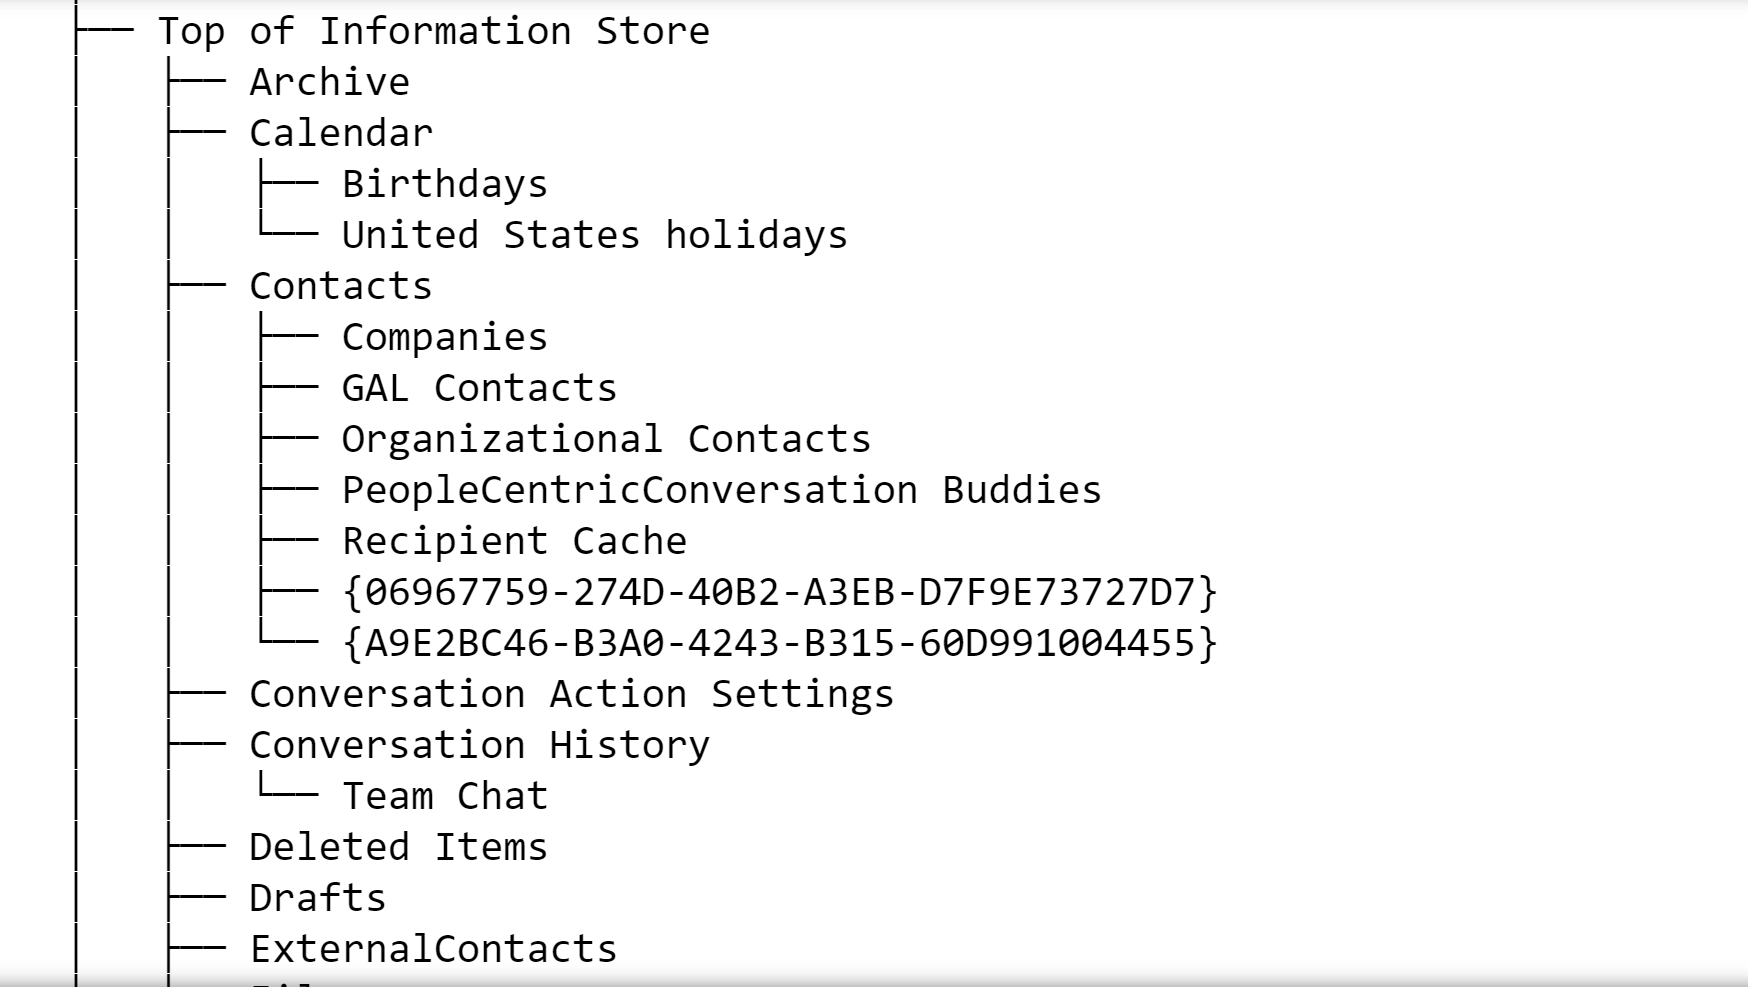

In [68]:
Image(filename='folder_struc.png',width=500, height=250)

**Number of e-mails per ID**  
We can also calculate the number of e-mails sent by each user as below. For this exercise I am considering the latest 30 emails and checking the frequency.

In [51]:
def get_latest_emails(account, folder_name, count):
    # get folder object
    folder = account.root / 'Top of Information Store' / folder_name
    # get all latest emails
    return folder.all().order_by('-datetime_received')[:count]

def count_senders(emails):
    counts = defaultdict(int) #using defaultdict to avoid "no key" error
    for email in emails:
        counts[email.sender.name] += 1
    return counts

emails = get_latest_emails(account, 'Inbox', 30)
counts = count_senders(emails)
df = pd.DataFrame.from_dict(counts, orient='index', columns=['count'])
from IPython.display import display, HTML
display(HTML(df.to_html()))

,count
OneWire,2
Alivia Smith,1
Commencement Info. (comminfo),1
Jesse Dang at Mapbox,1
Crunchbase,3
ASOS,1
ResearchGate,1
Logan at Planted,1
Denise White - WHITED5@UCMAIL.UC.EDU,1
Home Chef,1


## Dummy Service Request Table  
I have created a dummy Service Request table(created from a sample Dell SR dataset) which holds useful information about all the service requests in the system. The table has the following fields.  
1. Ticket No - A unique alphanumeric value indicating a service request.
2. Title - A string representing the title of the request.
3. Body - A string representing the body of the request.
4. Category - An integer indicating what category the issue belongs to.
5. Urgency - On a scale of 1 to 5 indicates how urgent the request is perceived to be
6. Status - Indicates what is the current status of the request.
7. Comments - Comments on the latest status change.  
  
  
Following table shows a glimpse of the table.  

In [105]:
cur_folder = os.getcwd()
file = os.path.join(cur_folder, 'data\SR_dummy_data.xlsx')
xl = pd.ExcelFile(file)
df=xl.parse("Sheet1")
df.head()

,ticket_no,title,body,category,urgency,Status,Comments
0,SRT0001,Password reset,Need password reset for use cmanu.12,4,3,closed,Issue resolved and password shared to the lead.
1,SRT0002,connection with xphx0102,Please open RDS ports to xphx0102,6,2,Pending,The issue belongs with network team please ass...
2,SRT0003,work experience user,work experience user hi work experience studen...,5,3,pending,Pending for more updates from the user
3,SRT0004,requesting for meeting,requesting meeting hi please help follow equip...,5,4,closed,Issue resolved. Meeting scheduled for 24th Oct...
4,SRT0005,reset passwords for external accounts,re expire days hi ask help update passwords co...,4,2,closed,Issue resolved hence closed


## Pattern Matching  
In this section we use simple regular expressions to match customer e-mails with possible queries. Python's **re** regular expression library has been used for this. Some of the patterns we are trying to match are as following. Also, all the Service Request IDs are of the form SRTXXXX where X is a digit.
Sample queries:  
* Need an update on SRTXXXX.
* What is happening with SRTXXXX?
* SRTXXXX - requires an update
* Could someone let me know the status of SRTXXXX?
* What's going on with SRTXXXX?  
  
  
Also, these queries will be nested inside a larger text like:  
***Hello Good Morning!! Hope you had a great weekend. I was hoping if someone could let me know what's happening with SRTXXXX?***  
The regular expressions will successfully match this query, identify the request number and query it against the table for latest updates.  

The patterns are first compiled as below.

In [107]:
regex_1 = re.compile('(looking|want|need|seek|seeking|request|requesting|get|please)'
                                            '\s([^.?]{0,6})(\s{0,1})'
                                            '(status|update)\s([^.?]{0,6})(\s{0,1})'
                                            '(srt[0-9]{4})')
regex_2 = re.compile('(looking|want|need|seek|seeking|request|requesting|get|please)'
                                             '\s([^.?]{0,6})(\s{0,1})(status)\s'
                                             '(update)\s([^.?]{0,6})(\s{0,1})'
                                             '(srt[0-9]{4})')
regex_3 = re.compile('(what|what\'s|could|would)\s'
                                       '(is|are)?\s?'
                                       '(you|the|your)?\s?'
                                       '(guys|people|fellows|team)?\s?'
                                       '(doing|happening|going on)?\s?'
                                       '(with|of)?\s?'
                                       '(update|status)?\s?'
                                       '(about|on|of|of the)?\s?'
                                       '(srt[0-9]{4})\?')
regex_4 = re.compile('(can|would|could|you)?\s?'
                                  '(you|your|anyone|someone|could|would)+\s?'
                                  '(guys|people|fellows|team)?\s?(please)?\s?'
                                  '(let|tell)?\s?'
                                  '(us|me|my team|our people)?\s?'
                                  '(know|update)\s?'
                                  '(us|me)?\s?'
                                  '(of|on|about|regarding)\s?'
                                  '(status|the status)\s'
                                  '(of|of this|of the|of the below)?\s?'
                                  '(sr|request|service request|srt)?\s?'
                                  '([:-;])?\s?'
                                  '(srt[0-9]{4})\?')  

regex_5 = re.compile('(srt[0-9]{4})\s?([:\-;].)?\s?(update|an update|status|needs)\s'
                     '(needed|required|update|an update)')

*****************************
### Status enquiry e-mail example  
  
Let us first look at an example where a mail is correctly classified as a status enquiry e-mail and a response is sent to the user.

In [149]:
sleep = int(100) #in a real world scenario this code checks the inbox every 100 seconds
now = UTC_NOW()
last_refresh_time = now - timedelta(seconds=sleep) #check for the last time the inbox was checked
unread_emails = account.inbox.filter(datetime_received__gt=last_refresh_time, is_read=False) #new unread e-mails
for email in unread_emails:          #print the content of all unread emails
    print(email.text_body+"\n")

Hello team,

I was wondering if you could update me on the status of SRT0001? It has been pending for a long time now and it would be great if you let me know what's happening?

Thanks,
Dummy User




**********************************************************************
As you can see above, the code displays the content of the mail. Now let's see how the regex matches this mail to a service request in the dummy table created earlier!Also, a screenshot of the message recevied. This is my first e-mail box which is the dummy customer service mailbox.

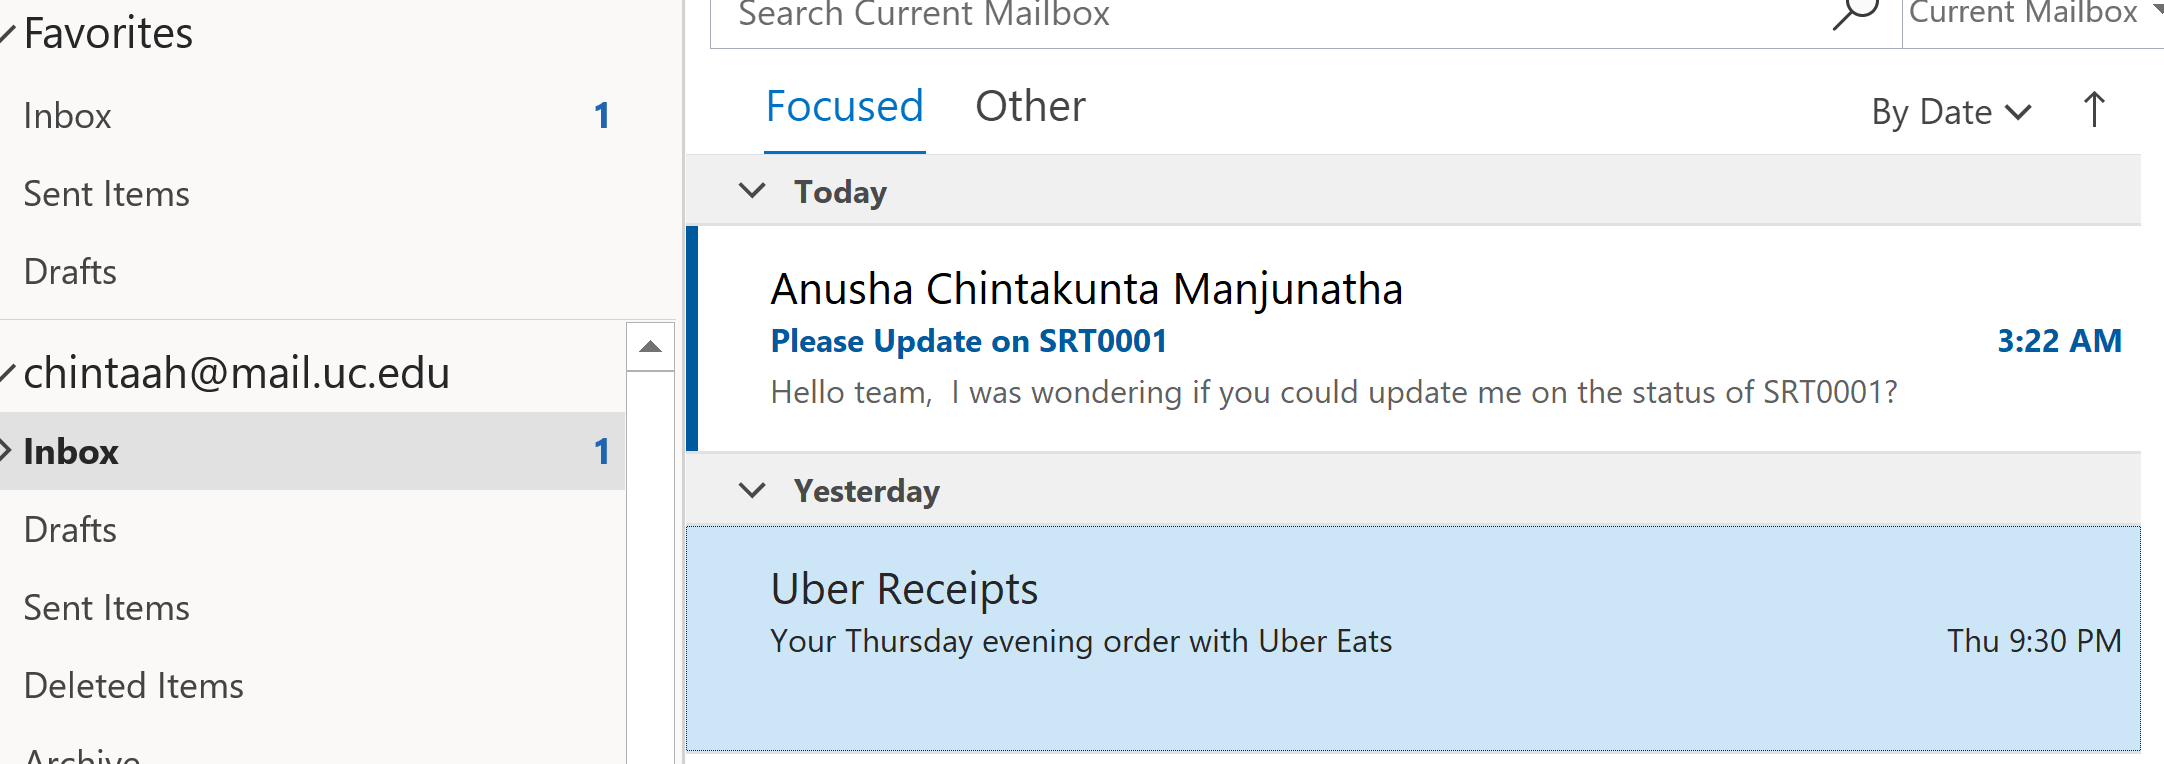

In [132]:
Image(filename='images/received.png',width=700, height=350)

In [150]:
#This function returns the Title,Status and Comments on the Service Request
def get_latest_sr_status(sr_number):
    sr_number = sr_number.upper()
    df_subset = df.loc[df['ticket_no'] == sr_number]
    title = df_subset.title.to_string()
    comments = df_subset.Comments.to_string()
    status = df_subset.Status.to_string()
    return(title, comments, status)

#This function matches the email body with the regular expressions compiled earlier and returns the SRT number if there is
#a match, else returns 0
def status_update_regex(email):
    email = email.lower()
    if regex_1.search(email) != None:
        return re.search('srt[0-9]{4}',str(regex_1.search(email))).group(0)
    elif regex_2.search(email) !=None:
        return re.search('srt[0-9]{4}',str(regex_2.search(email))).group(0)
    elif regex_3.search(email) !=None:
        return re.search('srt[0-9]{4}',str(regex_3.search(email))).group(0)
    elif regex_4.search(email) != None:
        return re.search('srt[0-9]{4}',str(regex_4.search(email))).group(0)
    elif regex_5.search(email) != None:
        return re.search('srt[0-9]{4}',str(regex_5.search(email))).group(0)
    else:
        return 0

#This function sends the response e-mail to the user
def send_response_email(user_email_id,sr_number,sr_status):
    m = Message(
    account=account,
    folder=account.sent,
    subject= "Status update for "+ sr_number.upper(),
    body='Please see below for the latest update on ' + sr_number.upper() +"\n\n" +
    "Title: "+sr_status[0][5:]+"\n"+"Status: "+sr_status[2][5:]+"\n"+"Comments: "+sr_status[1][5:]+"\n\n"+
    "This is an automated e-mail. A human will soon contact you if you require further assistance \n\
    Please request for a callback by logging on to http:\\somedummylink.com\callback. \n\
    Have a nice day! \n\n\
    Support Team\n\
    Dummy Company",
    to_recipients=[Mailbox(email_address=user_email_id)])
    print(repr(m.subject)+"\n")
    print(repr(m.body)+"\n")
    m.send_and_save()

In [151]:
#for each unread email call the status_update_regex and the emails that match the query pattern
#If there is a match get the SRT number from the mail and send relevant update to the user
#else print "this is not a status update email"
#if there are no unread emails print "no unread emails"
if(len(unread_emails)!=0):
    for index_num, email in enumerate(unread_emails):
        body = '\n'.join(l for l in email.text_body.split('\n') if l)
        sr_number = status_update_regex(body)
        if(sr_number !=1):
            sr_status = get_latest_sr_status(sr_number)
            user_email_id = email.sender.email_address
            send_response_email(user_email_id, sr_number,sr_status)
            print("response email sent successfully!")
        else:
            print("this is not an SR status enquiry email")
else:
    print("No unread e-mails")
    




'Status update for SRT0001'

'Please see below for the latest update on SRT0001\n\nTitle: Password reset\nStatus: closed\nComments: Issue resolved and password shared to the lead.\n\nThis is an automated e-mail. A human will soon contact you if you require further assistance \n    Please request for a callback by logging on to http:\\somedummylink.com\\callback. \n    Have a nice day! \n\n    Support Team\n    Dummy Company'

response email sent successfully!


********************************************************************************************************************************
We see the response e-mail as it is sent by the above code. The images show how the automated e-mail would look in a browser. This is my second personal e-mail id, the dummy user who had originally requested for a status update.

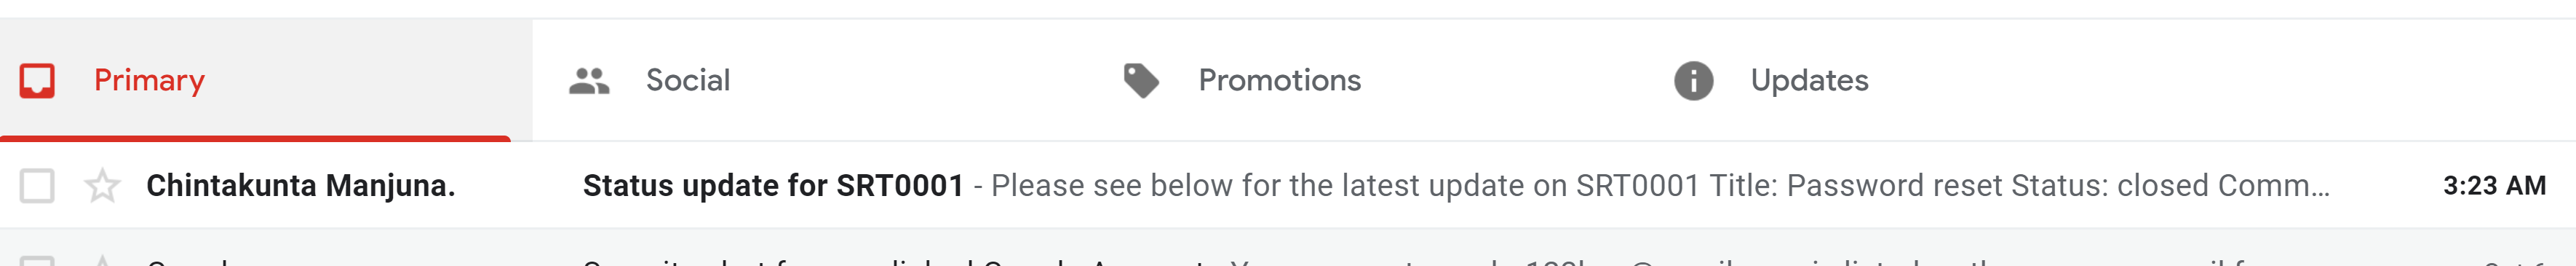

In [135]:
Image(filename='images/sent1.png',width=800, height=550)

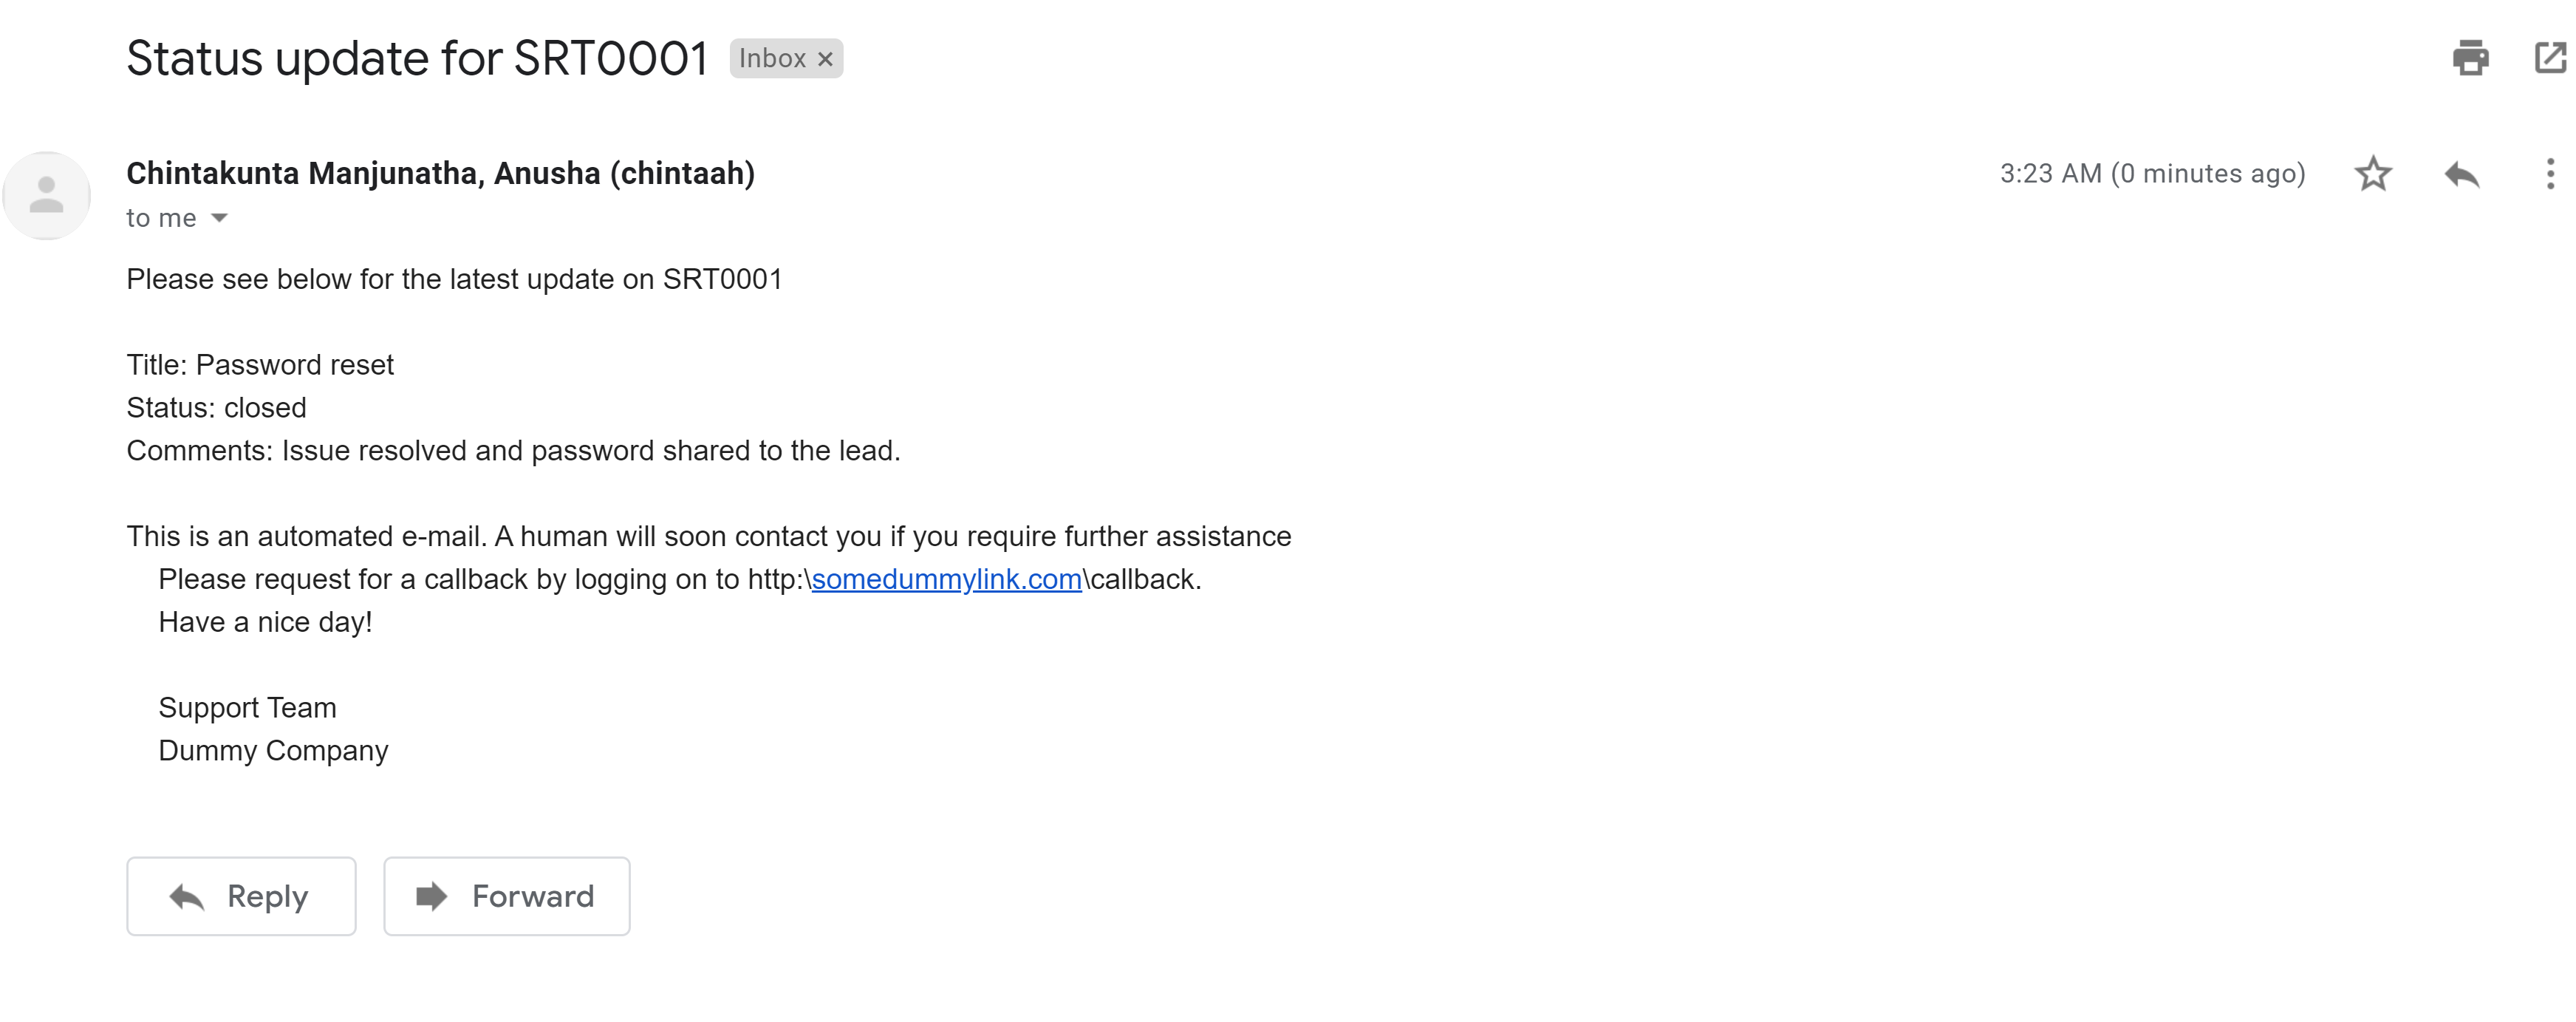

In [136]:
Image(filename='images/sent2.png',width=800, height=550)

************************************
### Non- status enquiry mail example  

Now let us look at an example where the code successfully recognizes an e-mail which is not a status enquiry. Eventhough the word used in this example is very similar to the other example, the regex correctly classifies this e-mail as a non-status enquiry e-mail.Eventhough the regex built for this project are greedy, for simple texts it seems to do a good job. However, more robust regular expressions will be required in the real world scenarios.

In [154]:
sleep = int(1000) #in a real world scenario this code checks the inbox every 100 seconds
now = UTC_NOW()
last_refresh_time = now - timedelta(seconds=sleep) #check for the last time the inbox was checked
unread_emails = account.inbox.filter(datetime_received__gt=last_refresh_time, is_read=False) #new unread e-mails
for email in unread_emails:          #print the content of all unread emails
    print(email.text_body+"\n")

Hello team,

Thank you for the update on SRT0003. Much appreciated!

Regards,
Dummy User2





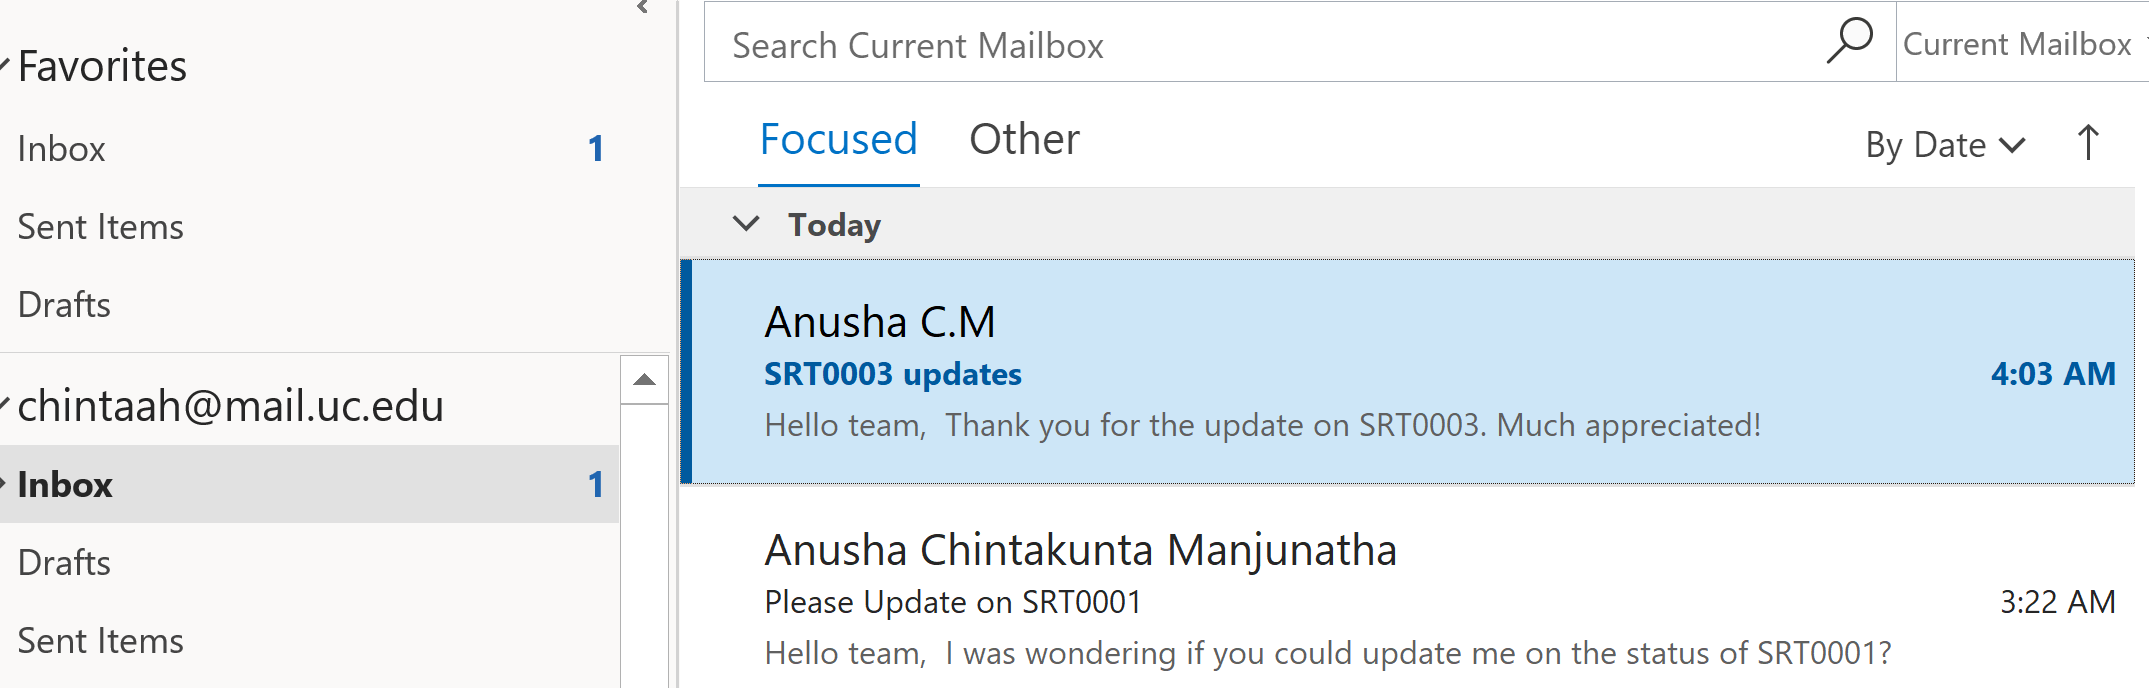

In [158]:
Image(filename='images/received2.png',width=700, height=550)

In [156]:
if(len(unread_emails)!=0):
    for index_num, email in enumerate(unread_emails):
        body = '\n'.join(l for l in email.text_body.split('\n') if l)
        sr_number = status_update_regex(body)
        if(sr_number !=0):
            sr_status = get_latest_sr_status(sr_number)
            user_email_id = email.sender.email_address
            send_response_email(user_email_id, sr_number,sr_status)
            print("response email sent successfully!")
        else:
            print("this is not an SR status enquiry email")
else:
    print("No unread e-mails")
    

this is not an SR status enquiry email


The regex correctly identifies this e-mail and hence no updates are sent to the user. If you want to try other examples please feel free to download the code. Make sure that the config.py is updated with your credentials. Thank you for reading!